# Notebook to Start Pulling it All Together

See comments at bottom about exclusing PSF 2016 and 2017 data

## Nitrate 15 m to 20 m

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xarray as xr

In [4]:
foramt = "{:.2}"
myformat = {'bias': foramt, 'rmse': foramt, 'swillmott': foramt, 'slopedev': foramt, 'const': foramt,
                         'systematic': foramt, 'nonsystematic':foramt, 
                    'spread': foramt}

In [5]:
with xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc') as mesh:
    deptht = mesh.gdept_1d[0].values
    print (deptht)

[  0.50000027   1.50000314   2.5000115    3.50003055   4.50007042
   5.50015083   6.50031022   7.50062342   8.50123623   9.50243254
  10.5047653   11.50931127  12.51816684  13.53541212  14.56898216
  15.63428737  16.76117342  18.00713456  19.48178514  21.38997868
  24.10025665  28.22991514  34.68575798  44.51772486  58.48433368
  76.58558445  98.06295924 121.8665184  147.08945807 173.11448217
 199.57304923 226.26030574 253.06663733 279.93454976 306.83419736
 333.75016973 360.6745318  387.60320347 414.53408835 441.46610968]


In [6]:
def bias(df, obs, mod):
    diffy = df[mod] - df[obs]
    return diffy.count(), diffy.mean()

In [7]:
def rmse(df, obs, mod):
    return (np.sqrt(((df[mod] - df[obs])**2).mean()))

In [8]:
def swillmott(df, obs, mod):
    meanobs = df[obs].mean()
    return (((df[mod] - df[obs])**2).sum()
            /(( (df[mod] - meanobs).abs() + (df[obs] - meanobs).abs() )**2).sum())

In [9]:
def slope_inter(df, obs, mod):
    X = df[obs]
    y = df[mod]
    X = sm.add_constant(X)

    # Fit and make the predictions by the model
    model = sm.OLS(y, X, missing='drop').fit()
    predictions = model.predict(X)
    
    nonsyst = np.sqrt(((y - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obs])**2).mean())
    return model.params[obs], model.params['const'], systematic, nonsyst

In [10]:
def spread(df, obs, mod):
    return 1 - ((df[mod] - df[mod].mean())**2).mean() / ((df[obs] - df[obs].mean())**2).mean() 

In [11]:
def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])
    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)
    return temp1

In [12]:
def plot_and_stats(temp1, name, idepth, jdepth):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    vmax = 36
    vmin = 0
    print (deptht[idepth], deptht[jdepth])
    counts, xedges, yedges, color = ax.hist2d(temp1.NO3[(temp1.k >= idepth) & (temp1.k <= jdepth)], 
                                              temp1.mod_nitrate[(temp1.k >= idepth) & (temp1.k <= jdepth)], 
                                           bins=np.arange(vmin, vmax, 0.5), norm=LogNorm());
    fig.colorbar(color)
    number, tbias = bias(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'NO3', 'mod_nitrate')
    trmse = rmse(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'NO3', 'mod_nitrate')
    tswillmott = swillmott(temp1[temp1.k >=idepth], 'NO3', 'mod_nitrate')
    m, c, syst, nonsyst = slope_inter(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'NO3', 'mod_nitrate')
    tspread = spread(temp1[temp1.k >= idepth], 'NO3', 'mod_nitrate')
    ax.plot([vmin, vmax], [vmin, vmax], 'w-');
    xr = np.arange(vmin, vmax, 0.5)
    ax.plot(xr, c + m * xr, 'r-');
    ax.arrow(13, 31, 0, 1-tbias/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(13, 33, 0, -1+tbias/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(14, 31, 0, 1-syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(14, 33, 0, -1+syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(15, 31, 0, 1-nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(15, 33, 0, -1+nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
          'swillmott': tswillmott,
          'slopedev': 1-m,
          'const': c,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    ax.text(13-0.2, 26, 'bias', rotation=90)
    ax.text(14-0.2, 25, 'systematic', rotation=90)
    ax.text(15-0.2, 24, 'non-systematic', rotation=90)
    ax.set_title(f'{name}, Nitrate between 15 and 20 m');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2


In [13]:
def plot_and_stats_sal(temp1, name, idepth, jdepth):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    vmax = 35
    vmin = 20
    print (deptht[idepth], deptht[jdepth])
    counts, xedges, yedges, color = ax.hist2d(temp1.SA[(temp1.k >= idepth) & (temp1.k <= jdepth)], 
                                              temp1.mod_vosaline[(temp1.k >= idepth) & (temp1.k <= jdepth)], 
                                           bins=np.arange(vmin, vmax, 0.2), norm=LogNorm());
    fig.colorbar(color)
    number, tbias = bias(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'SA', 'mod_vosaline')
    trmse = rmse(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'SA', 'mod_vosaline')
    tswillmott = swillmott(temp1[temp1.k >=idepth], 'SA', 'mod_vosaline')
    m, c, syst, nonsyst = slope_inter(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'SA', 'mod_vosaline')
    tspread = spread(temp1[temp1.k >= idepth], 'SA', 'mod_vosaline')
    ax.plot([vmin, vmax], [vmin, vmax], 'w-');
    xr = np.arange(vmin, vmax, 0.5)
    ax.plot(xr, c + m * xr, 'r-');
    ax.arrow(13, 31, 0, 1-tbias/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(13, 33, 0, -1+tbias/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(14, 31, 0, 1-syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(14, 33, 0, -1+syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(15, 31, 0, 1-nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(15, 33, 0, -1+nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
          'swillmott': tswillmott,
          'slopedev': 1-m,
          'const': c,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    ax.text(13-0.2, 26, 'bias', rotation=90)
    ax.text(14-0.2, 25, 'systematic', rotation=90)
    ax.text(15-0.2, 24, 'non-systematic', rotation=90)
    ax.set_title(f'{name}, Salinity between 15 and 20 m');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2

In [26]:
pieces = ('/home/sallen/202007/H201812/ObsModel_201812_Bio_20150101-20151231.csv',
         '/home/sallen/202007/H201812/ObsModel_201812_Bio_20160101-20161231.csv',
         '/home/sallen/202007/H201812/ObsModel_201812_Bio_20170101-20171231.csv',
         '/home/sallen/202007/H201812/ObsModel_201812_PSF_20150101-20151231.csv',
  #       '/home/sallen/202007/H201905/ObsModel_201812_PSF_20160101-20161231.csv',
  #       '/home/sallen/202007/H201905/ObsModel_201812_PSF_20170101-20171231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_pug_20150101_20151231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_pug_20160101_20161231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_pug_20170101_20171231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_hplc_20150101_20151231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_hplc_20160101_20161231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_hplc_20170101_20171231.csv')

15.634287368141315 19.48178513731196


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812,620,-1.8,4.7,0.13,0.51,8.3,3.2,3.5,-0.079


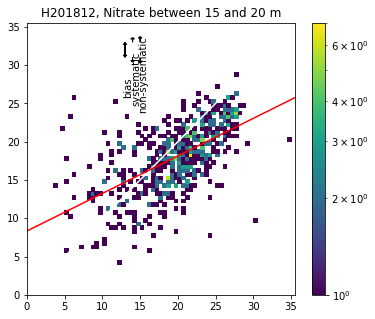

In [27]:
temp1 = read_pieces(pieces)
temp1['NO3'] = temp1.N.fillna(value=temp1.NO23).fillna(value=temp1['Nitrate_plus_Nitrite [umol/L]'])
idepth = 15
jdepth = 18
d201812 = plot_and_stats(temp1, 'H201812', idepth, jdepth)
d201812.style.format(myformat)

In [14]:
pieces = ('/home/sallen/202007/H201905/ObsModel_201905_Bio_20150101-20151231.csv',
         '/home/sallen/202007/H201905/ObsModel_201905_Bio_20160101-20161231.csv',
         '/home/sallen/202007/H201905/ObsModel_201905_Bio_20170101-20171231.csv',
         '/home/sallen/202007/H201905/ObsModel_201905_PSF_20150101-20151231.csv',
  #       '/home/sallen/202007/H201905/ObsModel_201905_PSF_20160101-20161231.csv',
  #       '/home/sallen/202007/H201905/ObsModel_201905_PSF_20170101-20171231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_pug_20150101_20151231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_pug_20160101_20161231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_pug_20170101_20171231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_hplc_20150101_20151231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_hplc_20160101_20161231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_hplc_20170101_20171231.csv')

15.634287368141315 19.48178513731196


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201905,620,-0.28,4.3,0.13,0.54,1.1e+01,2.9,3.2,0.34


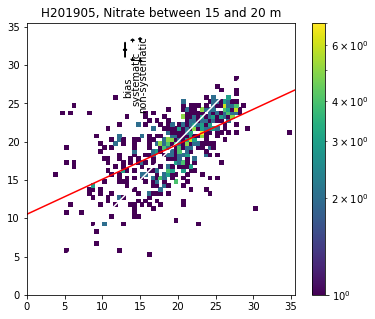

In [15]:
temp1 = read_pieces(pieces)
temp1['NO3'] = temp1.N.fillna(value=temp1.NO23).fillna(value=temp1['Nitrate_plus_Nitrite [umol/L]'])

d201905 = plot_and_stats(temp1, 'H201905', idepth, jdepth)
d201905.style.format(myformat)

In [16]:
pieces = ('/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_Bio_20150101-20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_Bio_20160101-20161231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_Bio_20170101-20171231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_PSF_20150101-20150630.csv',
 #        '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_PSF_20160101-20161231.csv',
 #        '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_PSF_20170101-20171231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_PUG_20150101-20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_PUG_20160101-20161231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_PUG_20170101-20171231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_hplc_20150101_20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_hplc_20160101_20161231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_hplc_20170101_20171231.csv')

15.634287368141315 19.48178513731196


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Cp2,509,-2.2,4.7,0.14,0.5,8.1,3.4,3.3,0.14


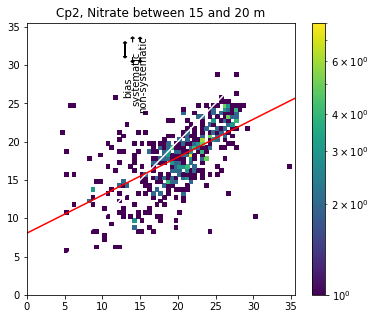

In [17]:
temp1 = read_pieces(pieces)
temp1['NO3'] = temp1.N.fillna(value=temp1.NO23).fillna(value=temp1['Nitrate_plus_Nitrite [umol/L]'])
dCp2 = plot_and_stats(temp1, 'Cp2', idepth, jdepth)
dCp2.style.format(myformat)

In [18]:
pieces = ('/home/sallen/202007/202007D-again/ObsModel_202007D-again_Bio_20150101-20151231.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_Bio_20160101-20161231.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_Bio_20170101-20171231.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_PSF_20150101-20151231.csv',
  #       '/home/sallen/202007/202007D-again/ObsModel_202007D-again_PSF_20160101-20161231.csv',
 #         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_PSF_20170101-20171231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pug_20150101_20151231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pug_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pug_20170101_20171231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_hplc_20150101_20151231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_hplc_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_hplc_20170101_20171231.csv'
        )

15.634287368141315 19.48178513731196


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Dagain,620,-0.68,4.2,0.13,0.56,1e+01,3.0,2.9,0.35


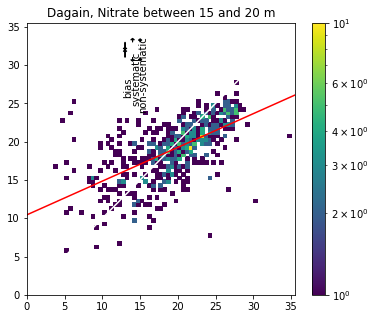

In [19]:
temp1 = read_pieces(pieces)
temp1['NO3'] = temp1.N.fillna(value=temp1.NO23).fillna(value=temp1['Nitrate_plus_Nitrite [umol/L]'])
Dagain = plot_and_stats(temp1, 'Dagain', idepth, jdepth)
Dagain.style.format(myformat)

In [31]:
pieces = ('/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_Bio_20150101-20151231.csv',
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_bot_20160101_20161231.csv',
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_bot_20170101_20171231.csv',
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_PSF_20150101-20151231.csv',
  #       '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_PSF_20160101-20161231.csv',
 #         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_PSF_20170101-20171231.csv',
          '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_pug_20150101_20151231.csv',
          '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_pug_20160101_20161231.csv',
          '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_pug_20170101_20171231.csv',
          '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_hplc_20150101_20151231.csv',
          '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_hplc_20160101_20161231.csv',
          '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_hplc_20170101_20171231.csv'
        )

15.634287368141315 19.48178513731196


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
D-noCil,620,-1.7,4.6,0.14,0.53,8.8,3.3,3.3,0.19


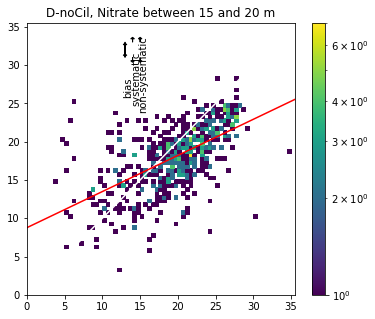

In [32]:
temp1 = read_pieces(pieces)
temp1['NO3'] = temp1.N.fillna(value=temp1.NO23).fillna(value=temp1['Nitrate_plus_Nitrite [umol/L]'])
DnoC = plot_and_stats(temp1, 'D-noCil', idepth, jdepth)
DnoC.style.format(myformat)

In [20]:
pieces = ('/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_Bio_20150101-20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_bot_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_bot_20170101_20171231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_PSF_20150101-20151231.csv',
 #        '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_psf_20160101_20161231.csv',
 #        '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_psf_20170101_20171231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pug_20150101_20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pug_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pug_20170101_20171231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_hplc_20150101_20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_hplc_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_hplc_20170101_20171231.csv')

15.634287368141315 19.48178513731196


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
D-lowR,620,-0.46,4.2,0.13,0.58,1.1e+01,3.1,2.9,0.36


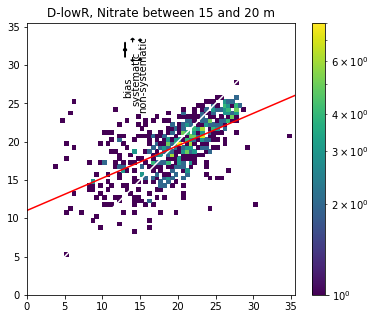

In [21]:
temp1 = read_pieces(pieces)
temp1['NO3'] = temp1.N.fillna(value=temp1.NO23).fillna(value=temp1['Nitrate_plus_Nitrite [umol/L]'])
DlowR = plot_and_stats(temp1, 'D-lowR', idepth, jdepth)
DlowR.style.format(myformat)

In [22]:
pieces = ('/home/sallen/202007/202007F/ObsModel_202007F_bot_20150101_20151231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_bot_20160101_20161231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_bot_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_psf_20150101_20151231.csv',
#          '/home/sallen/202007/202007F/ObsModel_202007F_psf_20160101_20161231.csv',
#          '/home/sallen/202007/202007F/ObsModel_202007F_psf_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_pug_20150101_20151231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_pug_20160101_20161231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_pug_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_hplc_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_hplc_20160101_20161231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_hplc_20170101_20171231.csv')

15.634287368141315 19.48178513731196


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
F,620,-0.63,4.3,0.14,0.61,1.1e+01,3.2,2.8,0.35


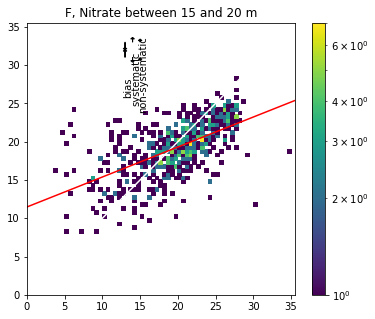

In [23]:
temp1 = read_pieces(pieces)
temp1['NO3'] = temp1.N.fillna(value=temp1.NO23).fillna(value=temp1['Nitrate_plus_Nitrite [umol/L]'])
modF = plot_and_stats(temp1, 'F', idepth, jdepth)
modF.style.format(myformat)

In [24]:
def highlight_max_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = abs(s) == abs(s).max()
    is_min = abs(s) == abs(s).min()
    color = []
    for v, v2 in zip(is_max, is_min):
        if v:
            color.append('red')
        elif v2:
            color.append('darkgreen')
        else:
            color.append('black')
    return ['color: %s' % color[i] for i in range(len(is_max))]

In [33]:
alltogether = pd.concat([d201812, d201905, dCp2, Dagain, DnoC, DlowR, modF], axis=0)
foramt = "{:.2}"
alltogether.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812,620,-1.8,4.7,0.13,0.51,8.3,3.2,3.5,-0.079
H201905,620,-0.28,4.3,0.13,0.54,1.1e+01,2.9,3.2,0.34
Cp2,509,-2.2,4.7,0.14,0.5,8.1,3.4,3.3,0.14
Dagain,620,-0.68,4.2,0.13,0.56,1e+01,3.0,2.9,0.35
D-noCil,620,-1.7,4.6,0.14,0.53,8.8,3.3,3.3,0.19
D-lowR,620,-0.46,4.2,0.13,0.58,1.1e+01,3.1,2.9,0.36
F,620,-0.63,4.3,0.14,0.61,1.1e+01,3.2,2.8,0.35


In [166]:
pieces = ('/home/sallen/202007/202007F/ObsModel_202007F_ctd_20150101_20151231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_psfts_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_ctd_20160101_20161231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_psfts_20160101_20161231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20160101_20161231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_ctd_20170101_20171231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_psfts_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20170101_20171231.csv',)

15.634287368141315 19.48178513731196


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
F,41451,0.026,0.54,0.031,0.25,7.3,0.24,0.48,0.0037


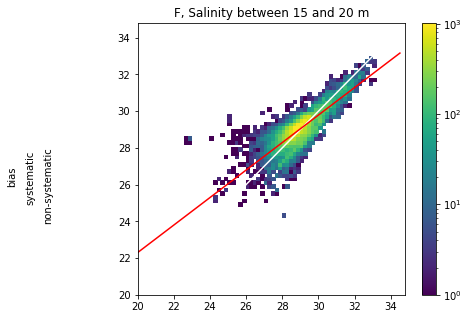

In [167]:
temp1 = read_pieces(pieces)
modF = plot_and_stats_sal(temp1, 'F', idepth, jdepth)
modF.style.format(myformat)

# 2016 and 2017 PSF Nutrient Data

Reason for exclusion

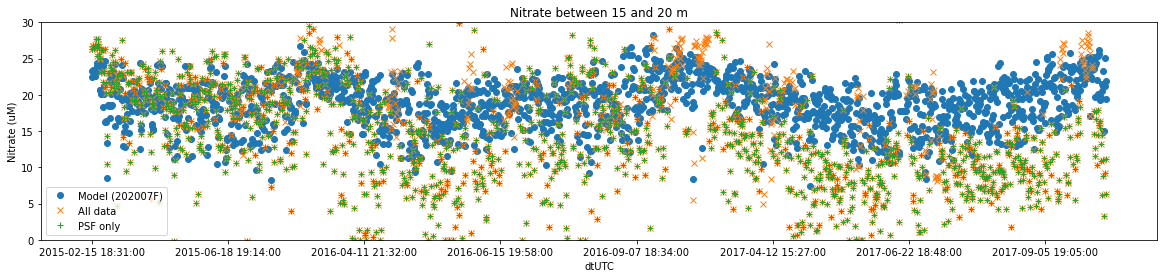

In [195]:
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
#temp1.set_index('dtUTC', inplace=True)
#temp1.sort_index(inplace=True)
temp1.mod_nitrate[(temp1.k >= idepth) & (temp1.k <= jdepth)].plot(marker='o', linewidth=0, label="Model (202007F)");
temp1.NO3[(temp1.k >= idepth) & (temp1.k <= jdepth)].plot(marker='x', linewidth=0, label= "All data");
temp1.NO23[(temp1.k >= idepth) & (temp1.k <= jdepth)].plot(marker='+', linewidth=0, label="PSF only");
ax.legend()
ax.set_ylabel('Nitrate (uM)')
ax.set_title('Nitrate between 15 and 20 m')
fig.savefig('NitrateSubSurface.png')

ax.set_ylim(0, 30);

From Rich's Atlas:  
However, note that the scatter pattern in the2016 and especially the 2017 CitSci dataset looksqualitatively different than the pattern in otheryears, with a lower and rounder shape. Deep con-centrations are also lower.  The reason for thisis not clear, however the analytical proceduresused in those years were different than in theother years. A difference in data quality for thoseyears is also suggested by comparison with themore limited high-quality data collected by gov-ernment scientists (Fig.12), which does not showaqualitativedifference in the appearance of thescatter over all years. Thus, we suspect that the2017 measurements especially are also affectedby procedural biases. These biases will not affectcomparisons within that year, but make year-to-year comparisons more uncertain.

From plot above and from Rich's note, we exclude all PSF nutrient data for 2016 and 2017.